# Task 1

Yifan Luo, u7351505

## 0. Load Packages

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Read and convert images

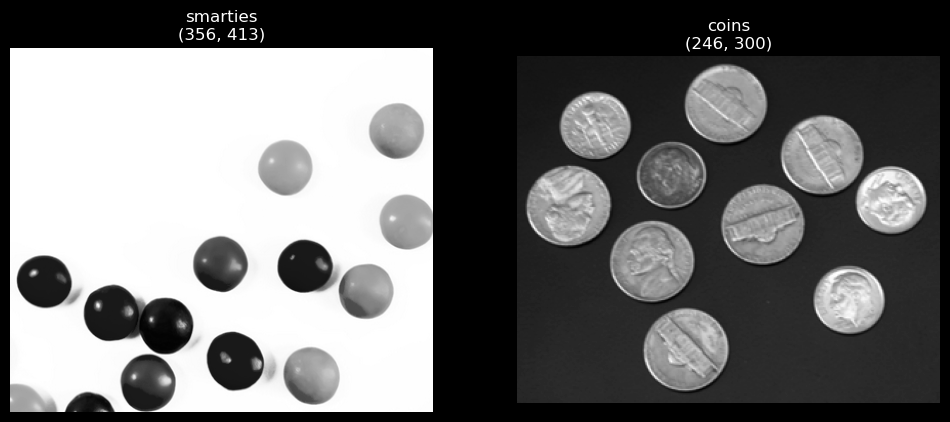

In [58]:
# read RGB/RGBA images with the format (H, W, C)
smarties_rgb = cv2.imread('Task1/images/smarties.png')  # (356, 413, 3)
coins_rgba = cv2.imread('Task1/images/coins.png')        # (246, 300, 4)

# convert to grayscale images
smarties = cv2.cvtColor(smarties_rgb, cv2.COLOR_RGB2GRAY)  # (356, 413)
coins = cv2.cvtColor(coins_rgba, cv2.COLOR_RGB2GRAY)        # (246, 300)

# show grayscale images
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(smarties, cmap='gray')
ax[0].set_title(f"smarties\n{smarties.shape}")
ax[0].set_axis_off()
ax[1].imshow(coins, cmap='gray')
ax[1].set_title(f"coins\n{coins.shape}")
ax[1].set_axis_off()

## 2. Apply the Canny edge detector

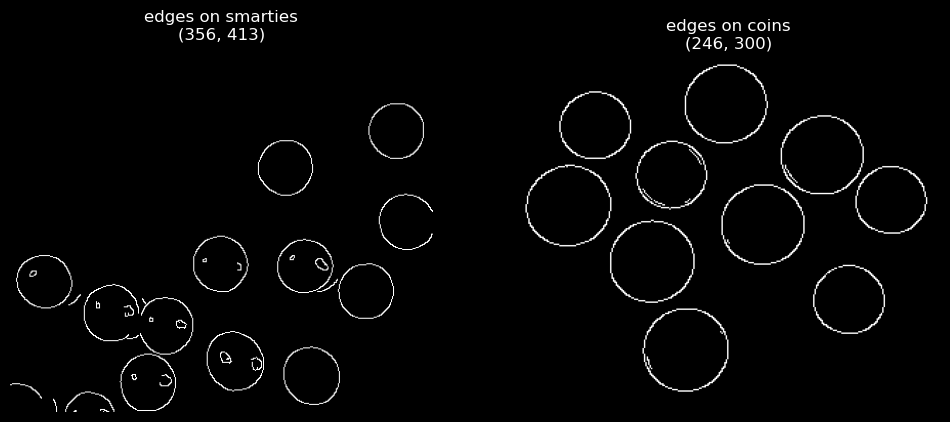

In [59]:
# apply Canny edge detecotrs on grayscale images
edge_smarties = cv2.Canny(smarties, threshold1=230, threshold2=320)
edge_coins = cv2.Canny(coins, threshold1=300, threshold2=600)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(edge_smarties, cmap='gray')
ax[0].set_title(f"edges on smarties\n{edge_smarties.shape}")
ax[0].set_axis_off()
ax[1].imshow(edge_coins, cmap='gray')
ax[1].set_title(f"edges on coins\n{edge_coins.shape}")
ax[1].set_axis_off()

## 3. Implement the Hough transform function

In [60]:
def hough_circle_transform(
    edge,
    threshold_ratio=0.8,
    radius_increment=1,
    circle_centre_increment=[1, 1],
    theta_increment=(2 * np.pi / 180),
    radius_range=[5, 35],
    non_max_suppression=True,
    *args,
    **kwargs
):
    """Implementation of the Hough transform function with non-maximum suppression.

    Args:
        edge (np.ndarray): The Canny edge detection result.
        threshold_ratio (float, optional): Filter small votes. Defaults to 0.8.
        radius_increment (int, optional): The increment of radius during. Defaults to 1.
        circle_centre_increment (list, optional): The increment of the circle centre. Defaults to [1, 1].
        theta_increment (tuple, optional): The increment of theta during. Defaults to (2 * np.pi / 180).
        radius_range (list, optional): The preset radius range. Defaults to [5, 35].
        non_max_suppression (bool, optional): Whether to apply non-maximum suppression. Defaults to True.

    Returns:
        List[int, int, int]: A list of votes [a, b, r] in descending order.
    """
    # initialise a matrix for recording votes
    a_range = int(edge.shape[1] + 2 * radius_range[1] // circle_centre_increment[0])  # padding
    b_range = int(edge.shape[0] + 2 * radius_range[1]// circle_centre_increment[1])   # padding
    r_range = int((radius_range[1] - radius_range[0]) // radius_increment)
    vote = np.zeros((a_range, b_range, r_range))
    # iterate over the edge image and accumulate votes
    for x in range(0, edge.shape[1], circle_centre_increment[0]):
        for y in range(0, edge.shape[0], circle_centre_increment[1]):
            # skip if no edge detected
            if edge[y, x] == 0:
                continue
            # iterate over all the possible theta
            for theta in np.arange(0, 2 * np.pi, theta_increment):
                # iterate over all the possible radius within the range
                for radius in np.arange(radius_range[0], radius_range[1], radius_increment):
                    # a = x - r * cos(θ)
                    candidate_a = x - radius * np.cos(theta)
                    # b = y - r * sin(θ)
                    candidate_b = y - radius * np.sin(theta)
                    # calculate the indices in the vote matrix
                    candidate_a_idx = int((candidate_a // circle_centre_increment[0]) + radius_range[1])
                    candidate_b_idx = int((candidate_b // circle_centre_increment[1]) + radius_range[1])
                    candidate_r_idx = int((radius - radius_range[0]) // radius_increment)
                    # vote if the index is valid
                    if (
                        (0 <= candidate_a_idx < vote.shape[0])
                        and (0 <= candidate_b_idx < vote.shape[1])
                        and (0 <= candidate_r_idx < vote.shape[2])
                    ):
                        vote[candidate_a_idx, candidate_b_idx, candidate_r_idx] += 1

    print(f"after voting: {np.count_nonzero(vote)}")
    # set votes that are lower than the threshold to zeros
    vote = np.where(vote < (threshold_ratio * np.max(vote)), 0, vote)
    print(f"after implying threshold: {np.count_nonzero(vote)}")
    # implement non-maximum suppression
    if non_max_suppression:
        vote = non_maximum_suppression(vote, 
                                       kwargs['threshold_a'], 
                                       kwargs['threshold_b'], 
                                       kwargs['threshold_r'])
        print(f"after non-max suppression: {np.count_nonzero(vote)}")

    # return a list of votes [a, b, r] in a descending order
    asc_idx = np.unravel_index(np.argsort(vote, axis=None), vote.shape)
    res = []
    for a_idx, b_idx, r_idx in zip(asc_idx[0][::-1][:np.count_nonzero(vote)], 
                                   asc_idx[1][::-1][:np.count_nonzero(vote)], 
                                   asc_idx[2][::-1][:np.count_nonzero(vote)]):
        res.append([(a_idx - radius_range[1]) * circle_centre_increment[0], 
                    (b_idx  - radius_range[1]) * circle_centre_increment[1], 
                    radius_range[0] + r_idx * radius_increment])
    return np.unique(res, axis=0).tolist()


def non_maximum_suppression(vote, threshold_a=20, threshold_b=20, threshold_r=20):
    """Implementation of non-maximum suppression.

    Args:
        vote (np.ndarray): The vote matrix.
        threshold_a (int, optional): The half window size in the vertical direction. Defaults to 20.
        threshold_b (int, optional): The hald window size in the horizontal direction. Defaults to 20.
        threshold_r (int, optional): The half window size for radius. Defaults to 20.

    Returns:
        _type_: _description_
    """
    a_len, b_len, r_len = vote.shape
    res = np.zeros_like(vote)
    # zero padding
    vote_pad = np.zeros(
        (a_len + 2 * threshold_a, b_len + 2 * threshold_b, r_len + 2 * threshold_r)
    )
    vote_pad[threshold_a : threshold_a + a_len,
             threshold_b : threshold_b + b_len,
             threshold_r : threshold_r + r_len] = vote
    # non-max suppression
    for a in range(threshold_a, threshold_a + a_len):
        for b in range(threshold_b, threshold_b + b_len):
            for r in range(threshold_r, threshold_r + r_len):
                if vote_pad[a, b, r] == 0:
                    continue
                # the neighbours around [a, b, r]
                # controlled by the three thresholds
                neighbours = vote_pad[
                    a - threshold_a : a + threshold_a + 1,
                    b - threshold_b : b + threshold_b + 1,
                    r - threshold_r : r + threshold_r + 1,
                ]
                # suppression if the vote is not the maximum in its neighbourhood
                if vote_pad[a, b, r] == np.max(neighbours):
                    res[a - threshold_a, b - threshold_b, r - threshold_r] = vote_pad[a, b, r]
                    
    return res

## 4. Implement non-maximum suppression

The implementation of `non_maximum_suppression` can be found in the **Task 1.3**.

## 5.Display circles

Detect circles in `coins.png`.

after voting: 1528133
after implying threshold: 8
after non-max suppression: 5


Text(0.5, 1.0, 'circles on coins')

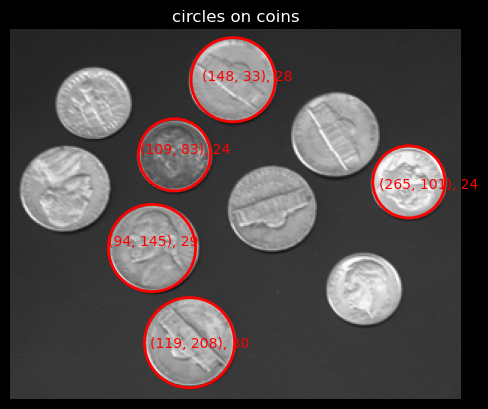

In [85]:
# detect coins
# circles_coins = hough_circle_transform(
#     edge_coins, 
#     threshold_ratio=0.7,
#     radius_increment=1,
#     circle_centre_increment=[1, 1],
#     theta_increment=(2 * np.pi / 180),
#     radius_range=[5, 35],
#     non_max_suppression=True,
#     threshold_a=20, 
#     threshold_b=20, 
#     threshold_r=20
# )

circles_coins = hough_circle_transform(
    edge_coins, 
    threshold_ratio=0.9,
    radius_increment=1,
    circle_centre_increment=[1, 1],
    theta_increment=1 * (2 * np.pi / 180),
    radius_range=[5, 35],
    non_max_suppression=True,
    threshold_a=20, 
    threshold_b=20, 
    threshold_r=20
)

fig, ax = plt.subplots()
ax.imshow(coins_rgba)
for x, y, r in circles_coins:
    circle = plt.Circle((x, y), r, color='red', linewidth=2,fill=False)
    ax.add_patch(circle)
    ax.text(x - r + np.random.randint(0, 8), 
            y + np.random.randint(-5, 5), 
            f"({x}, {y}), {r}", 
            color='red', fontsize=10)
ax.set_axis_off()
ax.set_title("circles on coins")

Detect circles in `smarties.png`.

after voting: 2070295
after implying threshold: 24
after non-max suppression: 12


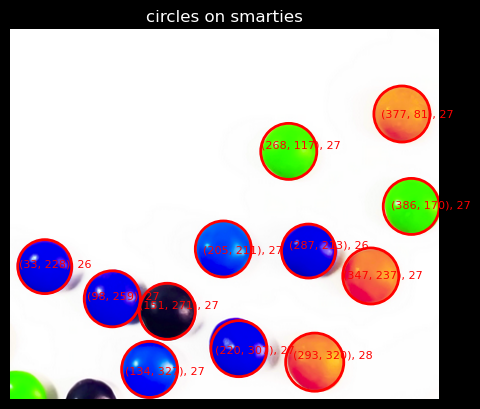

In [62]:
# detect smarties
circles_smarties = hough_circle_transform(
    edge_smarties, 
    threshold_ratio=0.7,
    radius_increment=1,
    circle_centre_increment=[1, 1],
    theta_increment=(2 * np.pi / 180),
    radius_range=[10, 35],
    non_max_suppression=True,
    threshold_a=20, 
    threshold_b=20, 
    threshold_r=20
)

fig, ax = plt.subplots()
ax.imshow(smarties_rgb)
for x, y, r in circles_smarties:
    circle = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(circle)
    ax.text(x - r + np.random.randint(0, 8), 
            y + np.random.randint(-5, 5), 
            f"({x}, {y}), {r}", 
            color='red', fontsize=8)
ax.set_title('circles on smarties')
ax.set_axis_off()